In [1]:
import h5py
import numpy as np


file = r"d:\mobidata-main\SpiralModulations\Xenocs_Wires_Spiral_1825mm\ref\Nylon_CarbonFibers_1825_test2_0_00003_img.edf"


 
with h5py.File(file, "r") as f:
    # Verify dataset structure
    print(f)




OSError: Unable to synchronously open file (file signature not found)

In [9]:
from mbipy.cupy.phase_retrieval.explicit import cst_csvt

In [23]:
import h5py

def explore_hdf5(file, group=None, level=0):
    """
    Explore l'architecture d'un fichier HDF5.
    
    Parameters:
        file: Le fichier HDF5 ouvert (avec h5py.File).
        group: Le groupe ou chemin à explorer (None pour explorer tout le fichier).
        level: Niveau actuel de la profondeur dans l'arborescence (pour l'indentation).
    """
    if group is None:
        group = file

    for key in group:
        item = group[key]
        indent = "  " * level  # Indentation pour montrer la hiérarchie
        if isinstance(item, h5py.Group):
            print(f"{indent}[Group] {key}")
            explore_hdf5(file, group=item, level=level + 1)  # Recurse dans le groupe
        elif isinstance(item, h5py.Dataset):
            print(f"{indent}[Dataset] {key} - shape: {item.shape}, dtype: {item.dtype}")

# Exemple d'utilisation

with h5py.File(file, "r") as h5file:
    print("Architecture du fichier HDF5 :")
    explore_hdf5(h5file)


Architecture du fichier HDF5 :
[Group] flyscan_0001
  [Group] ANATOMIX
    [Group] ans-c13-ei-l-u18.atx
      [Dataset] controller_record - shape: (), dtype: |S20
      [Dataset] gap - shape: (1,), dtype: float64
      [Dataset] gap_velocity - shape: (1,), dtype: float64
    [Group] ans-ca-machinestatus
      [Dataset] current - shape: (1,), dtype: float64
      [Dataset] function_mode - shape: (), dtype: |S6
      [Dataset] life_time - shape: (1,), dtype: float64
      [Dataset] name - shape: (), dtype: |S6
      [Dataset] probe - shape: (), dtype: |S5
      [Dataset] type - shape: (), dtype: |S24
    [Group] i13-lt-c01-ex-fent_h
      [Dataset] device_name - shape: (), dtype: |S20
      [Dataset] gap - shape: (1,), dtype: float64
      [Dataset] inside_up_position - shape: (1,), dtype: float64
      [Dataset] outside_down_position - shape: (1,), dtype: float64
      [Dataset] position - shape: (1,), dtype: float64
      [Dataset] position_offset - shape: (1,), dtype: float64
    [Gro

In [24]:
import h5py

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Trouve les chemins des datasets avec 3 dimensions dans un fichier HDF5.

    Parameters:
        file: Le fichier HDF5 ouvert (avec h5py.File).
        group: Le groupe ou chemin à explorer (None pour commencer au root).
        path: Chemin actuel dans l'arborescence.
        results: Liste pour stocker les chemins des datasets trouvés.

    Returns:
        Liste des chemins des datasets avec 3 dimensions.
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            # Recurse dans les sous-groupes
            find_datasets_with_dim_3(file, group=item, path=current_path, results=results)
        elif isinstance(item, h5py.Dataset):
            # Vérifie si le dataset a 3 dimensions
            if len(item.shape) == 3:
                results.append((current_path, item.shape))  # Ajoute le chemin et la forme
    return results

# Exemple d'utilisation
with h5py.File(file, "r") as h5file:
    print("Recherche des datasets avec 3 dimensions...")
    datasets_3d = find_datasets_with_dim_3(h5file)
    
    if datasets_3d:
        print("Datasets 3D trouvés :")
        for path, shape in datasets_3d:
            print(f"  - Chemin : {path}, Shape : {shape}")
    else:
        print("Aucun dataset avec 3 dimensions trouvé.")


Recherche des datasets avec 3 dimensions...
Datasets 3D trouvés :
  - Chemin : /flyscan_0001/scan_data/orca_image, Shape : (5600, 2048, 2048)


In [25]:
print(datasets_3d)

[('/flyscan_0001/scan_data/orca_image', (5600, 2048, 2048))]


In [37]:
layer = []
slice_number = 150

with h5py.File(file, "r") as f:
    for path, shape in datasets_3d:
        image = np.array(f[path][:, slice_number, :])
        name_image = (path.strip("/").split("/"))[-1]
        layer.append((image, {"name": name_image, "metadata":{"slice_number": slice_number, "paths": file, "key": path, "original_shape": shape}}, "image"))


In [36]:
print(layer)

import matplotlib.pyplot as plt



[(array([[ 7861,  7492,  7364, ..., 17818, 17644, 17738],
       [ 7666,  7419,  7622, ..., 17964, 17827, 17350],
       [ 7548,  7750,  7512, ..., 17561, 17973, 17698],
       ...,
       [ 7744,  7308,  7327, ..., 17597, 17827, 17698],
       [ 7353,  7419,  7253, ..., 17781, 17754, 17698],
       [ 7314,  7528,  7475, ..., 17892, 17864, 17853]], dtype=uint16), {'name': 'orca_image', 'metadata': {'slice_number': 150, 'paths': 'D:\\Soleil\\024_wt1_450mA_u18gap10p6_Au26um_orca_2x_3p075um_d1ts1037_50ms_5400proj\\024_wt1_450mA_u18gap10p6_Au26um_orca_2x_3p075um_d1ts1037_50ms_5400proj.nxs', 'key': '/flyscan_0001/scan_data/orca_image', 'shape': (5600, 2048, 2048)}}, 'image')]


In [39]:
dim = 1

index = [slice(None)] * 3  # Crée une liste de slices pour 3 dimensions
index[dim] = slice_number  # Remplace le slice correspondant à 'dim'

print(tuple(index))


(slice(None, None, None), 150, slice(None, None, None))


In [40]:
def read_nxs(paths, stack=False):
    """
    Lit les données des fichiers HDF5/NXS avec une seule sélection de slice et dimension,
    puis organise les layers pour chaque dataset.

    Parameters
    ----------
    paths : list[str] | str
        Chemins vers les fichiers à traiter.
    stack : bool
        Si True, empile les données des différents fichiers dans une seule couche.

    Returns
    -------
    list
        Une liste contenant des tuples pour chaque dataset, où chaque dataset est empilé
        sur tous les chemins (profondeur = nombre de chemins).
    """
    if isinstance(paths, str):
        paths = [paths]

    # Sélection unique des slices et dimensions
    print("Sélection de la slice et de la dimension pour tous les fichiers.")
    slices_info = display_and_select_slices_in_single_window(paths[0])

    # Préparation des layers
    dataset_layers = {}  # Stockera les images par dataset

    for path in paths:
        with h5py.File(path, "r") as h5file:
            print(f"Traitement du fichier : {path}")
            datasets_3d = find_datasets_with_dim_3(h5file)

            if not datasets_3d:
                print(f"Aucun dataset 3D trouvé dans {path}.")
                continue

            for keys, shape in datasets_3d:
                if keys in slices_info:
                    slice_info = slices_info[keys]
                    slice_number = slice_info["slice"]
                    dim = slice_info["dimension"]

                    # Crée un index pour extraire la slice dans la dimension spécifiée
                    index = [slice(None)] * 3
                    index[dim] = slice_number
                    # Charger les données selon l'index calculé
                    data = np.array(h5file[keys][tuple(index)])
                    data = np.squeeze(data)  # Supprimer la dimension de la slice

                    # Ajouter les données à l'ensemble correspondant au dataset
                    if keys not in dataset_layers:
                        dataset_layers[keys] = []

                    dataset_layers[keys].append(data)

    # Construire les layers en empilant les données pour chaque dataset
    layers = []
    for dataset_key, images in dataset_layers.items():
        # Empile les images de tous les chemins pour ce dataset
        stacked_images = np.stack(images, axis=0) if stack else images

        # Construire les métadonnées
        name_image = (dataset_key.strip("/").split("/"))[-1]
        metadata = {
            "slice_number": slice_number,
            "dimension": dim,
            "paths": paths,
            "dataset_key": dataset_key,
        }

        layers.append((stacked_images, {"name": name_image, "metadata": metadata}, "image"))

    return layers


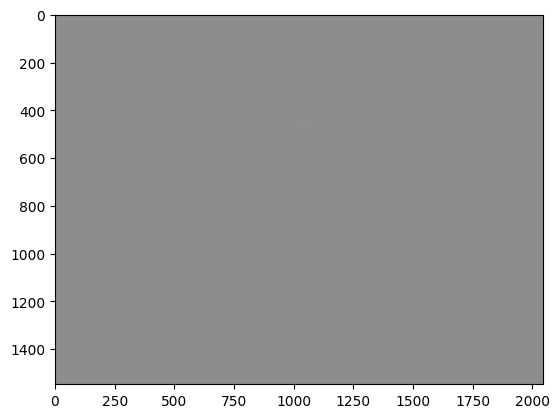

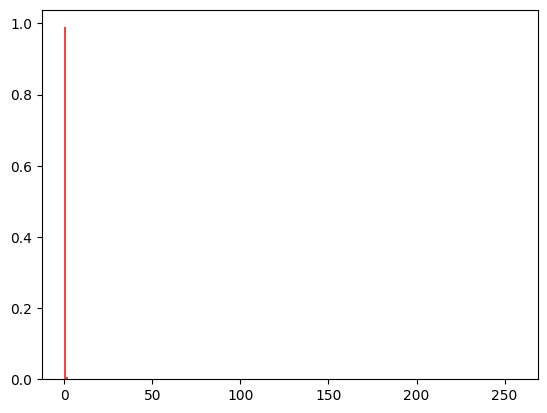

Max : 2435.23095703125
Min : -2998.72021484375


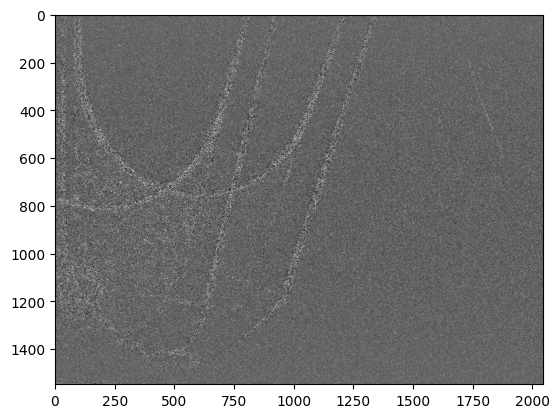

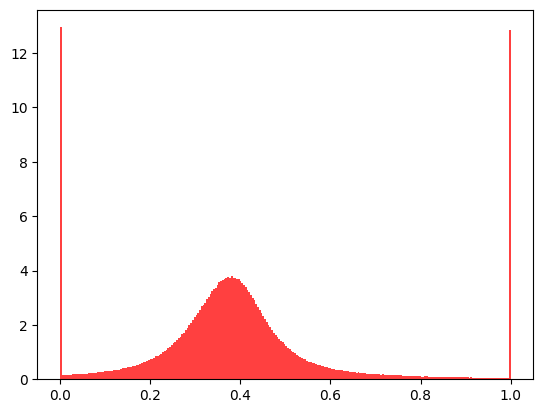

In [12]:
import fabio
import matplotlib.pyplot as plt
import numpy as np

path = r"C:\Users\clement.capdeville\Desktop\df_lcs.tif"

# open tif file avec fabio

image = fabio.open(path)
plt.imshow(image.data, cmap="gray")

# tracer l'histogramme
plt.figure()
plt.hist(image.data.flatten(), bins=256, range=(0, 256), density=True, alpha=0.75, color='r')
plt.show()

# trouver le max et le min

print(f"Max : {image.data.max()}")
print(f"Min : {image.data.min()}")

# normaliser pour que 20% des pixels soient saturés

gap = 5

max_value = np.percentile(image.data, 100 - gap)
min_value = np.percentile(image.data, gap)

normalized_image = np.clip((image.data - min_value) / (max_value - min_value), 0, 1)

plt.imshow(normalized_image, cmap="gray")
plt.show()

# tracer l'histogramme

plt.figure()
plt.hist(normalized_image.flatten(), bins=256, range=(0, 1), density=True, alpha=0.75, color='r')
plt.show()



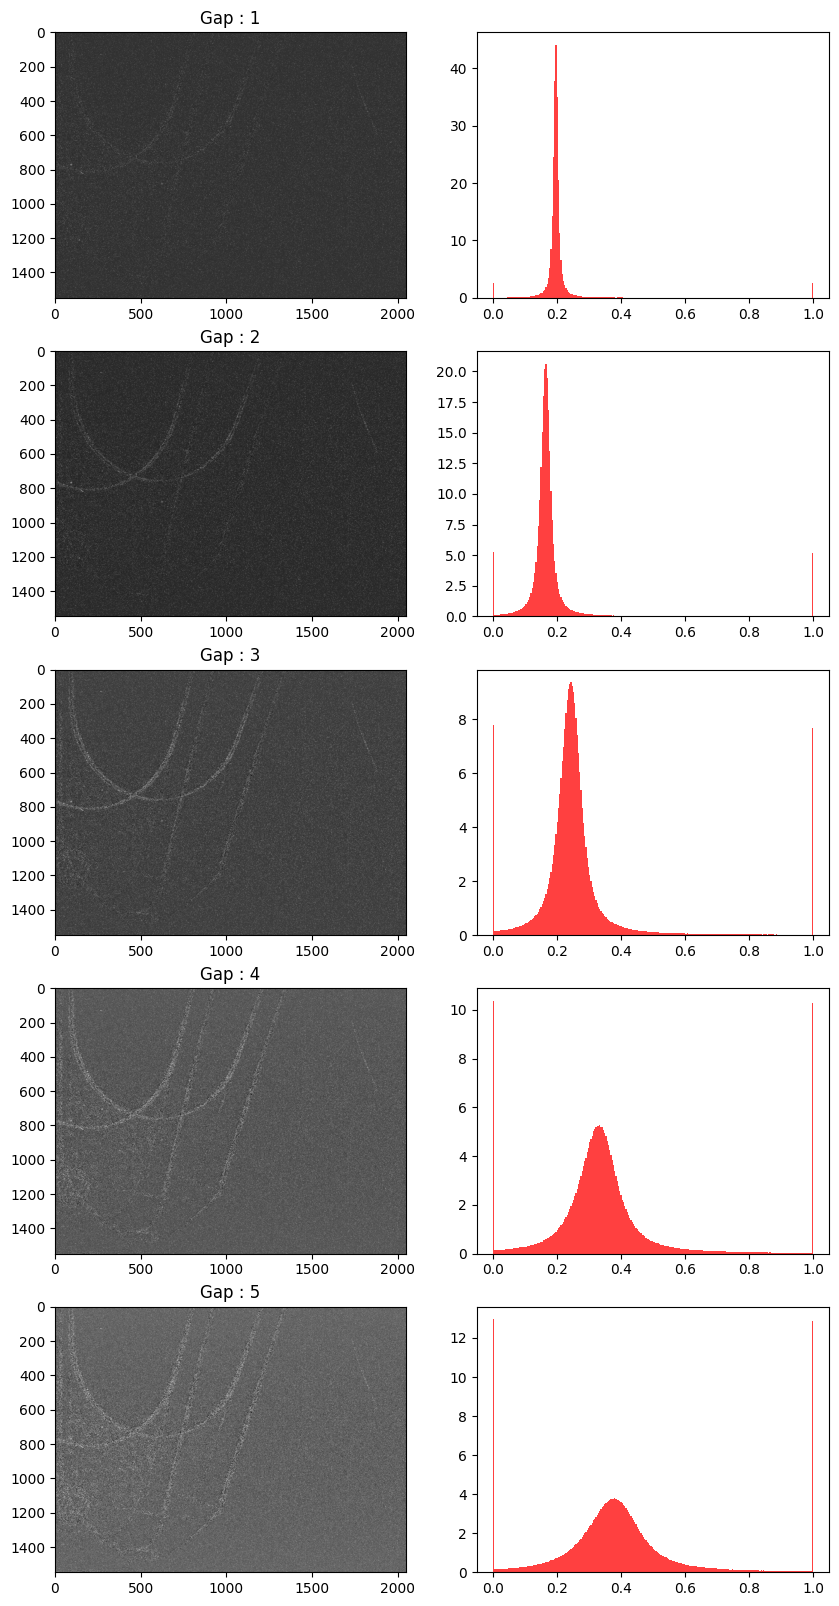

In [15]:
# tester plusieurs valeurs de gap et sur un subplot montrer l'image et l'histogramme

gaps = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, gap in enumerate(gaps):

    max_value = np.percentile(image.data, 100 - gap)
    min_value = np.percentile(image.data, gap)

    normalized_image = np.clip((image.data - min_value) / (max_value - min_value), 0, 1)

    axes[i, 0].imshow(normalized_image, cmap="gray")
    axes[i, 0].set_title(f"Gap : {gap}")

    axes[i, 1].hist(normalized_image.flatten(), bins=256, range=(0, 1), density=True, alpha=0.75, color='r')

plt.show()

(1028, 512)


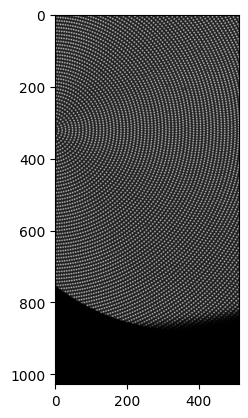

In [8]:
import fabio

file = r"d:\mobidata-main\SpiralModulations\Xenocs_Wires_Spiral_1825mm\ref\Nylon_CarbonFibers_1825_test2_0_00003_img.edf"

# Open the .edf file using fabio
image = fabio.open(file).data

# Print the image data
print(image.data)

import matplotlib.pyplot as plt

print(image.shape)


plt.imshow(image, cmap="gray")

